In [1]:

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from datetime import datetime
import logging
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
import gc  # for garbage collection
import os
from scipy import stats
from matplotlib.dates import YearLocator, DateFormatter

#import necessary packages 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, Optional,List, Dict
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import RectBivariateSpline
import xesmf as xe
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings

/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load in the data using xarray 
merra2_data=xr.open_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", engine="netcdf4")
nldas_data= xr.open_dataset("nldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
fldas_data= xr.open_dataset("fldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
gldas_data= xr.open_dataset("gldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
era5_data=xr.open_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',engine='cfgrib')

#create dataset dictionary 

datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Define variable names for each dataset
var_names = {
    'MERRA2': 'SFMC',  # Surface soil moisture content
    'NLDAS': 'SoilM_0_10cm',
    'FLDAS': 'SoilMoi00_10cm_tavg',
    'GLDAS': 'SoilMoi0_10cm_inst',
    'ERA5': 'swvl1'  # Volumetric soil water layer 1
}

coord_mapping = {
    'NLDAS': {'lat': 'lat', 'lon': 'lon'},
    'GLDAS': {'lat': 'lat', 'lon': 'lon'},
    'FLDAS': {'lat': 'Y', 'lon': 'X'},
    'ERA5': {'lat': 'latitude', 'lon': 'longitude'},
    'MERRA2': {'lat': 'lat', 'lon': 'lon'}
}


Normalization stats for MERRA2:
Original mean: 0.2624, std: 0.0585
Normalized mean: -0.0000, std: 1.0000

Normalization stats for NLDAS:
Original mean: 29.3776, std: 7.0058
Normalized mean: 0.0000, std: 1.0001

Normalization stats for FLDAS:
Original mean: 0.3622, std: 0.0497
Normalized mean: -0.0000, std: 1.0001

Normalization stats for GLDAS:
Original mean: 31.4795, std: 6.4977
Normalized mean: -0.0000, std: 1.0000

Normalization stats for ERA5:
Original mean: 0.3042, std: 0.0944
Normalized mean: 0.0000, std: 1.0000

Harmonizing time coordinates...
MERRA2 time range: 2013-01-01T00:30:00.000000000 to 2023-12-01T00:30:00.000000000
NLDAS time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
FLDAS time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
GLDAS time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
ERA5 time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000

=== Data Diagnostics Report ===

---

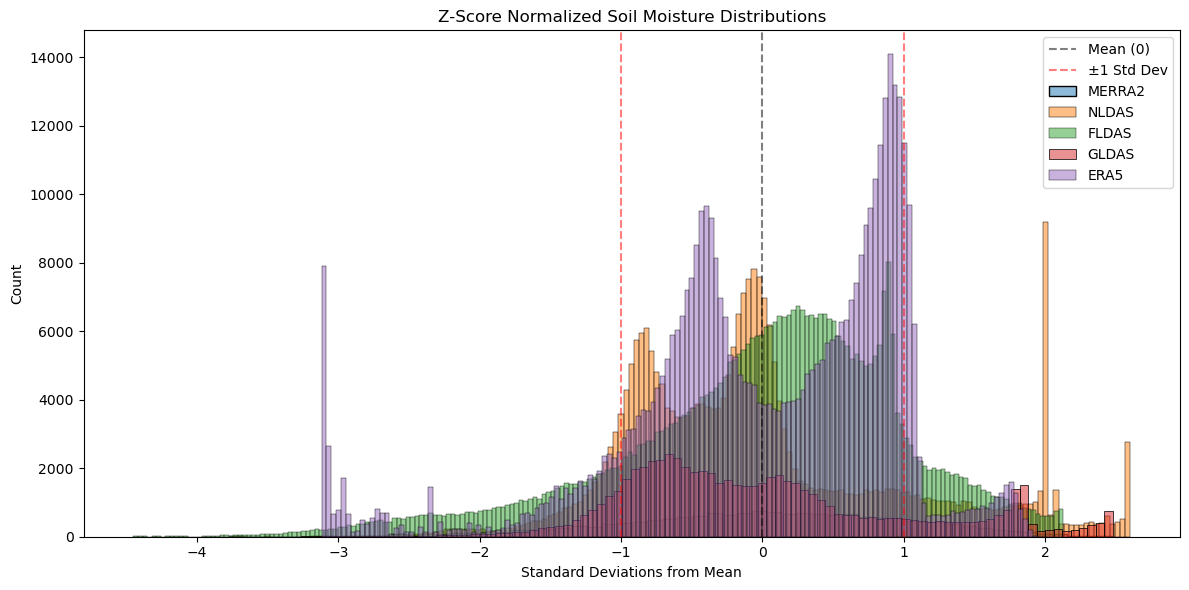


=== Cross-Dataset Comparison ===
         Normalized_Mean  Normalized_Std  Missing_Percentage  \
Dataset                                                        
MERRA2              -0.0             1.0              0.0000   
NLDAS               -0.0             1.0             10.4938   
FLDAS               -0.0             1.0             10.4641   
GLDAS               -0.0             1.0             10.2431   
ERA5                -0.0             1.0              3.3152   

         Outlier_Percentage  
Dataset                      
MERRA2               0.1690  
NLDAS                2.8422  
FLDAS                3.1350  
GLDAS                2.1159  
ERA5                 4.0174  


/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_88672/666276757.py:1802: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Dataset', y='Value',


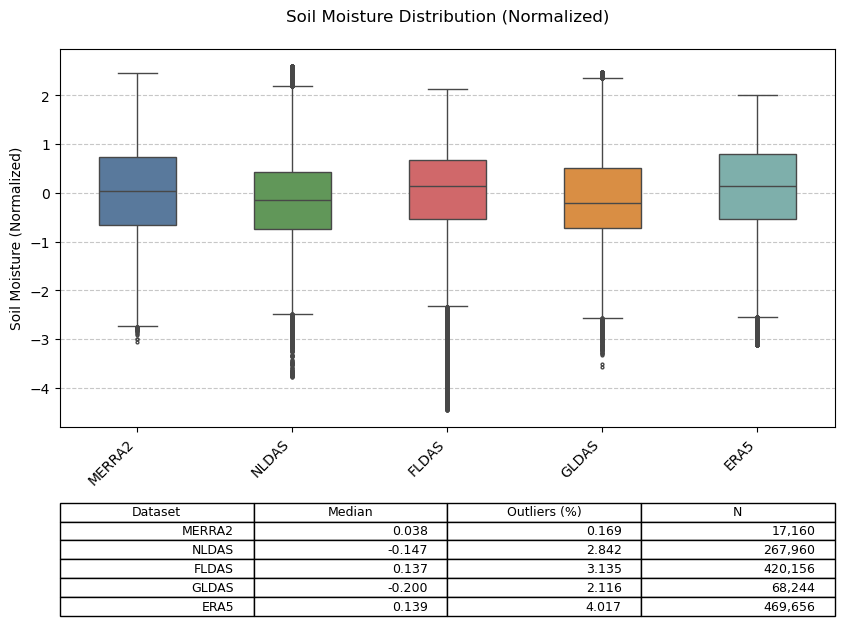


Summary Statistics:
------------------------------
Highest median: ERA5
Most outliers: ERA5 (4.0%)

Correlations:
------------------------------
MERRA2 vs NLDAS: -0.072
FLDAS vs MERRA2: -0.026
FLDAS vs NLDAS: 0.011
FLDAS vs GLDAS: 0.044
GLDAS vs MERRA2: -0.022
GLDAS vs NLDAS: -0.003
ERA5 vs MERRA2: 0.051
ERA5 vs NLDAS: -0.012
ERA5 vs FLDAS: 0.015
ERA5 vs GLDAS: 0.013

Initializing correlation calculation...

Processing MERRA2 dataset:
MERRA2 time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Successfully processed MERRA2
Successfully processed NLDAS
Successfully processed FLDAS
Successfully processed GLDAS

Processing ERA5 vs MERRA2
Found 132 common time periods
Time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000


/var/folders/w6/0tkgm2g11c9202ygt6n5r_qh0000gn/T/ipykernel_88672/666276757.py:825: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = stats.pearsonr(ts1_clean, ts2_clean)[0]


Valid correlation points: 3143/3680 (85.4%)
Mean Correlation: 0.7155
Shared variance: 51.2%

Processing ERA5 vs NLDAS
Found 132 common time periods
Time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Valid correlation points: 2629/3680 (71.4%)
Mean Correlation: 0.4697
Shared variance: 22.1%

Processing ERA5 vs FLDAS
Found 132 common time periods
Time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Valid correlation points: 2476/3680 (67.3%)
Mean Correlation: 0.5978
Shared variance: 35.7%

Processing ERA5 vs GLDAS
Found 132 common time periods
Time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Valid correlation points: 2505/3680 (68.1%)
Mean Correlation: 0.6008
Shared variance: 36.1%

Processing MERRA2 vs NLDAS
Found 132 common time periods
Time range: 2013-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Valid correlation points: 2588/3680 (70.3%)
Mean Correlation: 0.4950
Shared variance: 24.5%

Processing ME

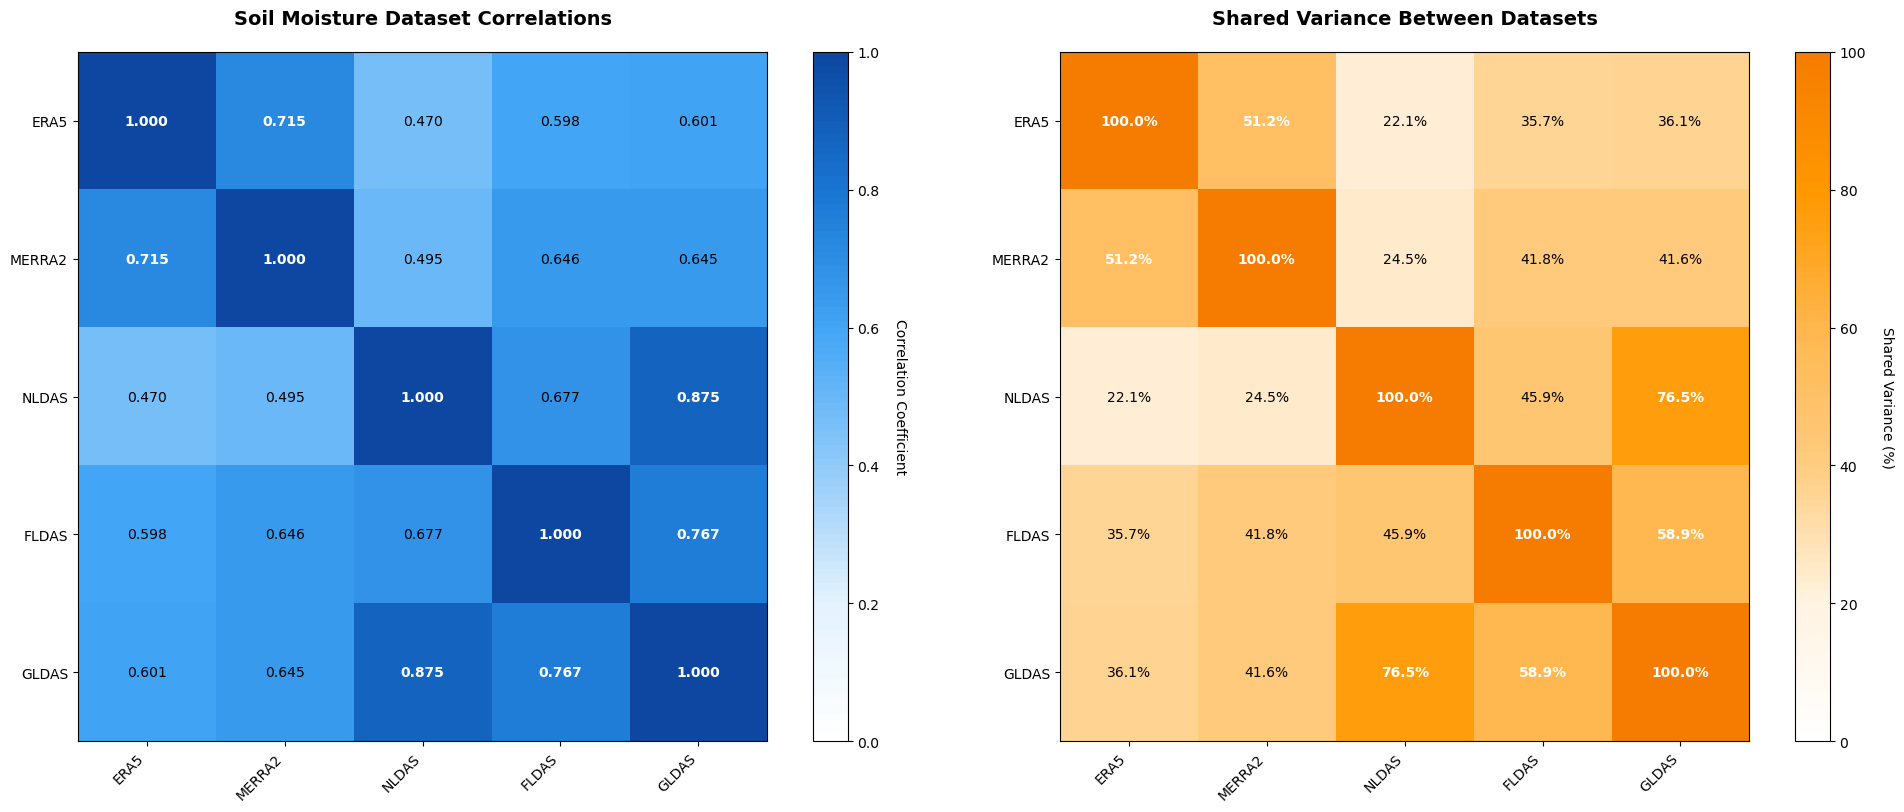

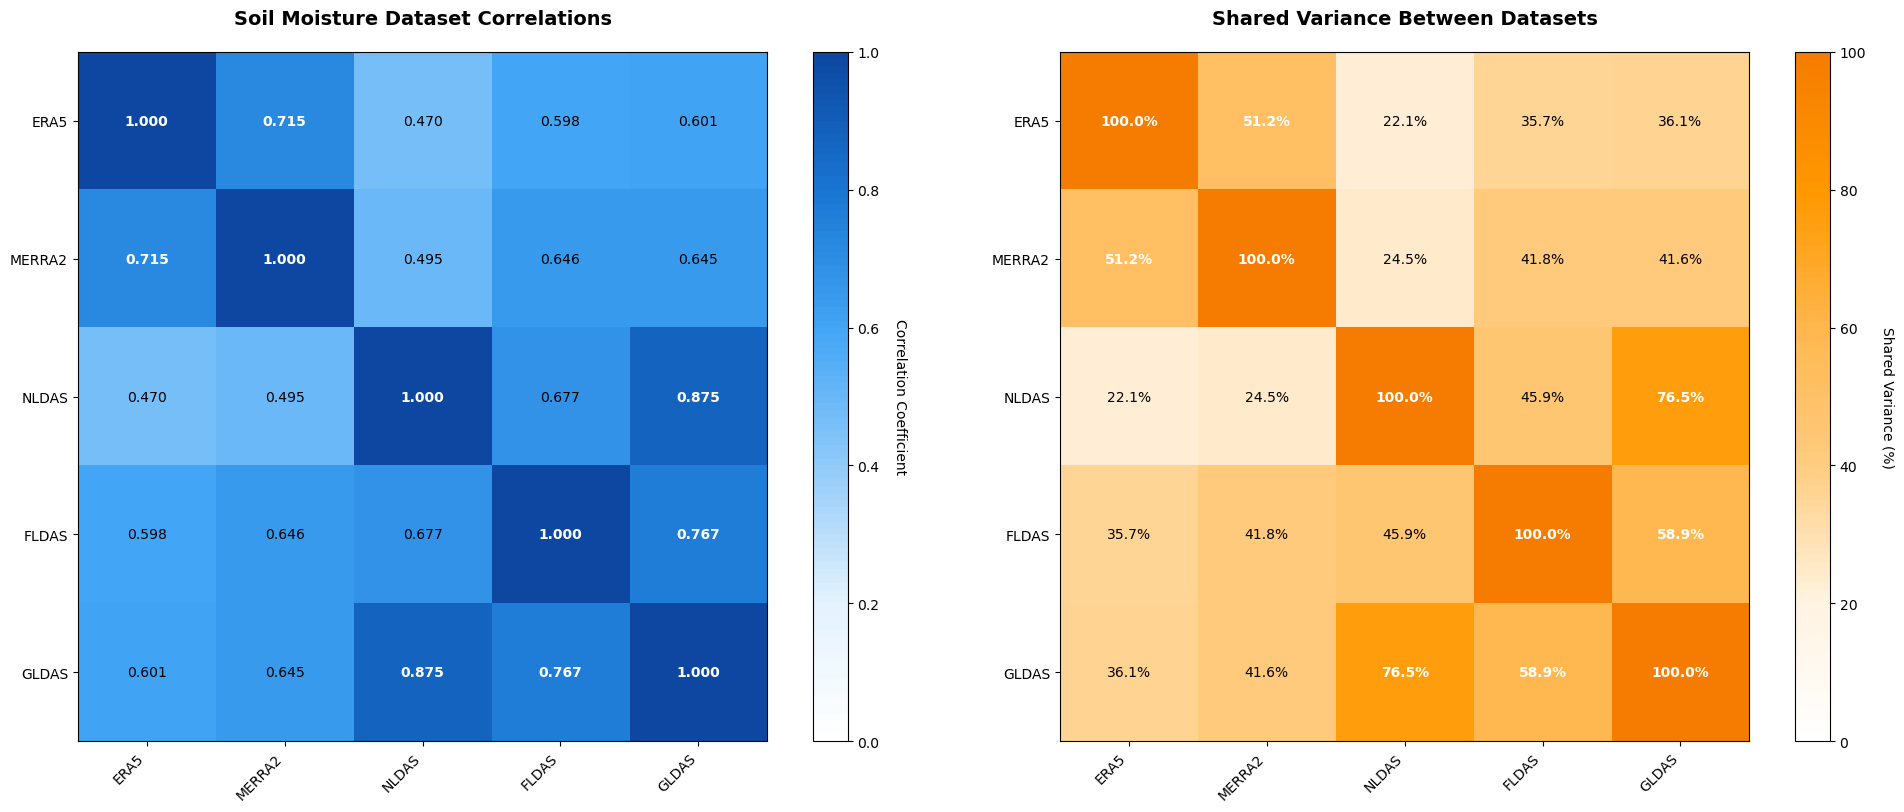

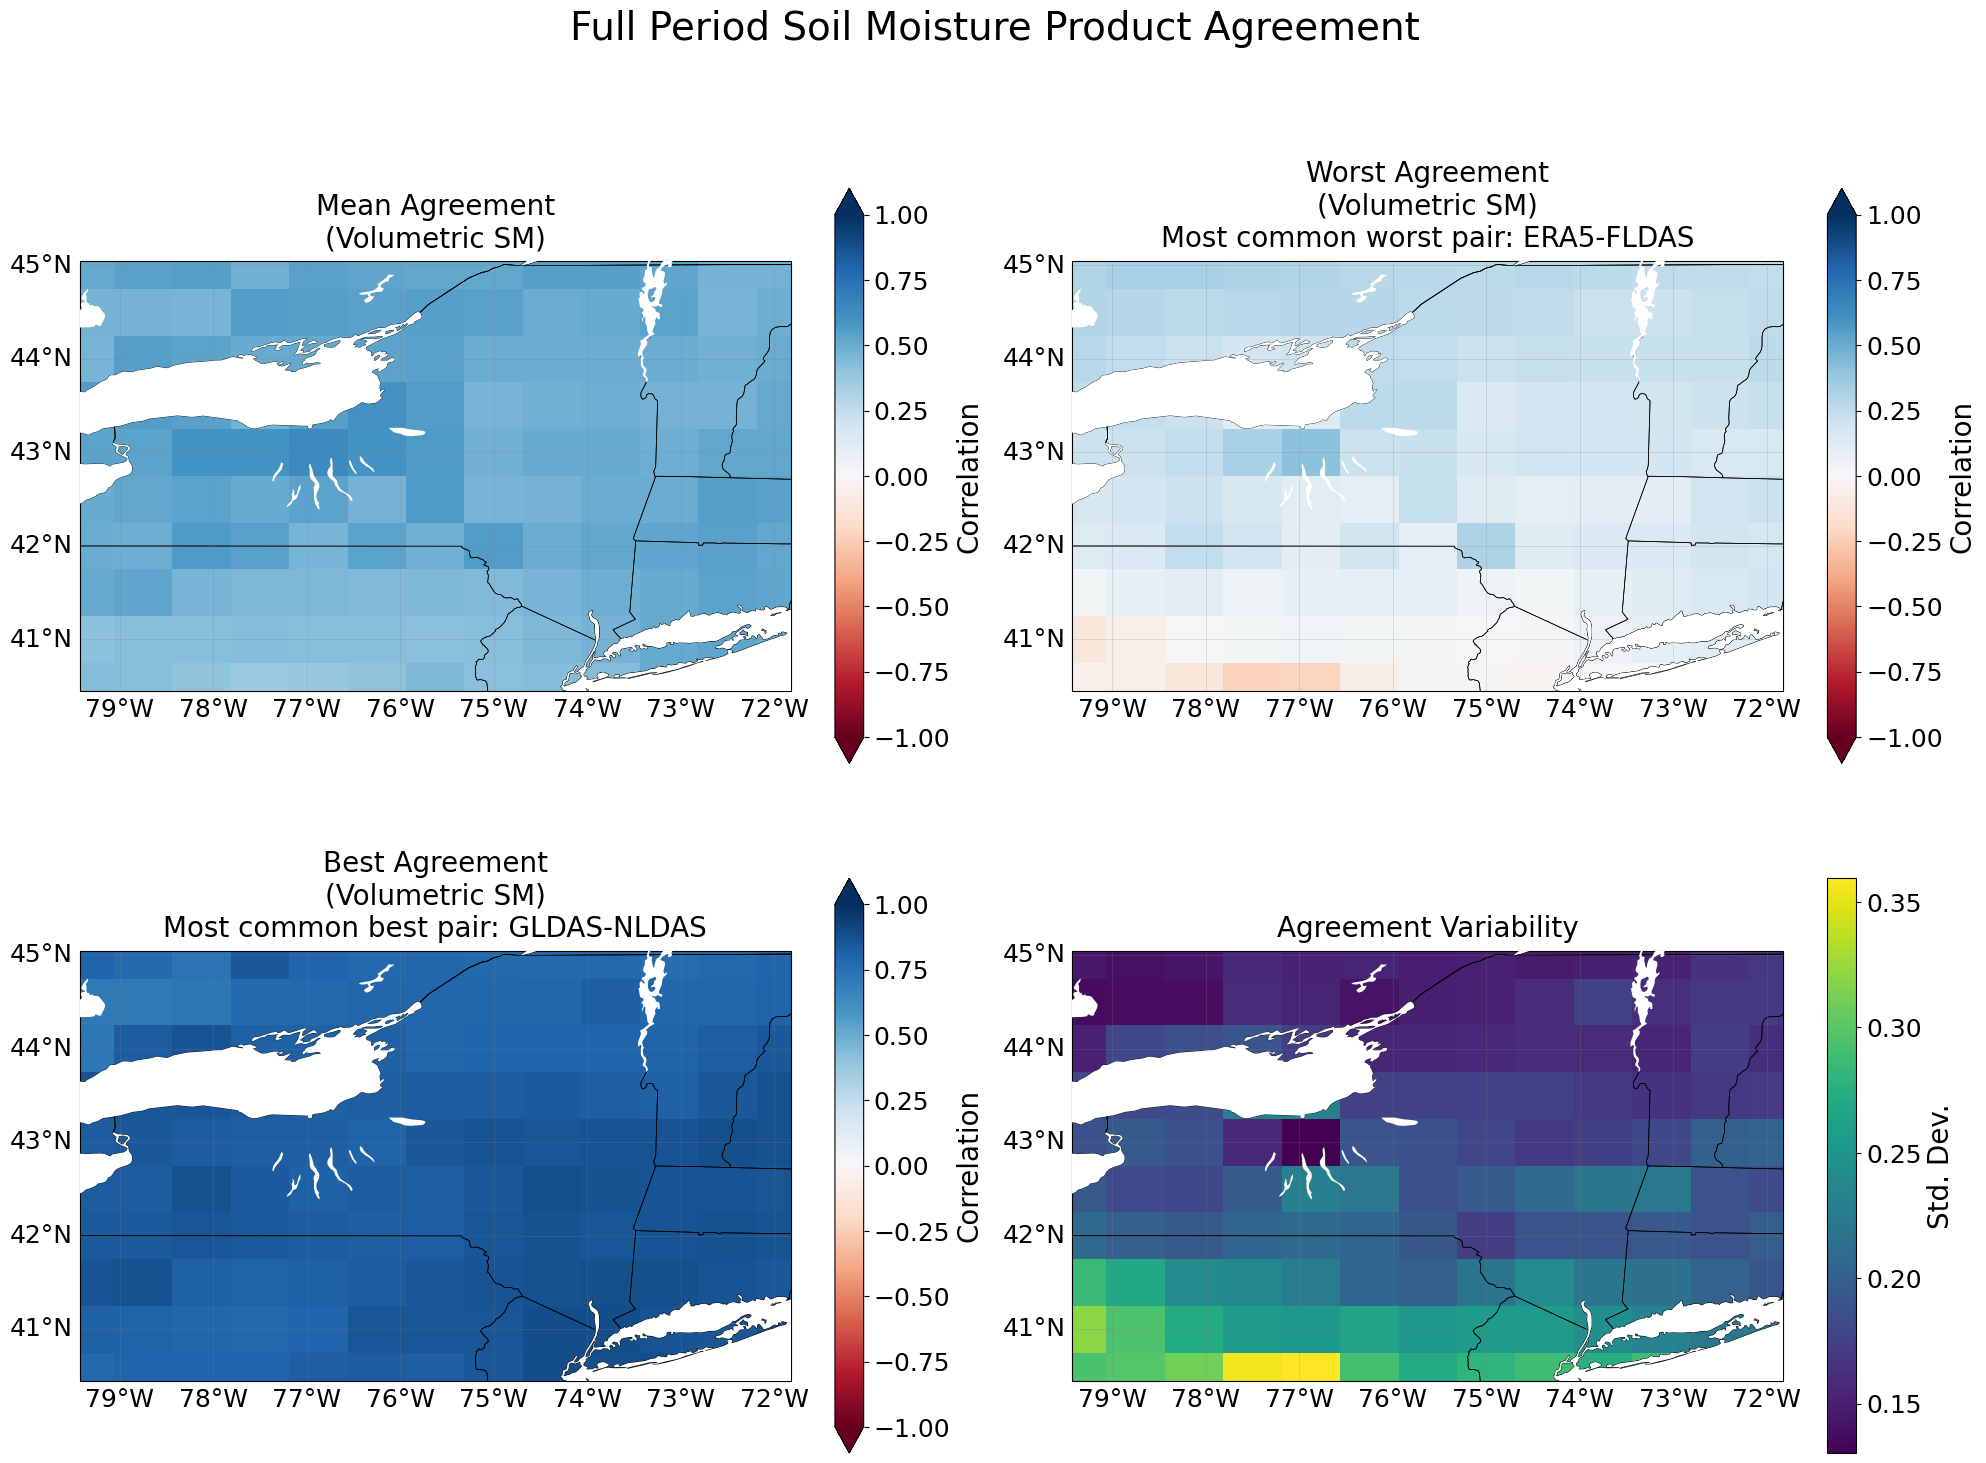

Calculating RMSE between datasets...

Processing: MERRA2_vs_NLDAS
Completed RMSE calculation for MERRA2_vs_NLDAS
Overall RMSE: 0.2669
Mean Temporal RMSE: 0.2603
Mean Spatial RMSE: 0.2500

Processing: MERRA2_vs_FLDAS
Completed RMSE calculation for MERRA2_vs_FLDAS
Overall RMSE: 0.2247
Mean Temporal RMSE: 0.2143
Mean Spatial RMSE: 0.2217

Processing: MERRA2_vs_GLDAS
Completed RMSE calculation for MERRA2_vs_GLDAS
Overall RMSE: 0.2401
Mean Temporal RMSE: 0.2333
Mean Spatial RMSE: 0.2301

Processing: MERRA2_vs_ERA5
Completed RMSE calculation for MERRA2_vs_ERA5
Overall RMSE: 0.2579
Mean Temporal RMSE: 0.2282
Mean Spatial RMSE: 0.2538

Processing: NLDAS_vs_FLDAS
Completed RMSE calculation for NLDAS_vs_FLDAS
Overall RMSE: 0.2814
Mean Temporal RMSE: 0.2667
Mean Spatial RMSE: 0.2749

Processing: NLDAS_vs_GLDAS
Completed RMSE calculation for NLDAS_vs_GLDAS
Overall RMSE: 0.1282
Mean Temporal RMSE: 0.1184
Mean Spatial RMSE: 0.1203

Processing: NLDAS_vs_ERA5
Completed RMSE calculation for NLDAS_vs_ER

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 1200x2200 with 0 Axes>

In [1]:

# Required imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xesmf as xe
import gc
from contextlib import contextmanager
from typing import Dict, Tuple, Optional, List, Union
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


class SoilMoistureAnalyzer:
    
    def decompose_by_season(self, data):
        """Split data into seasonal components."""
        if isinstance(data, xr.Dataset):
            for var_name in ['SFMC', 'SoilM_0_10cm', 'SoilMoi00_10cm_tavg', 'SoilMoi0_10cm_inst', 'swvl1']:
                if var_name in data:
                    data = data[var_name]
                    break
        
        months = pd.DatetimeIndex(data.time.values).month
        seasons = [self.get_season(m) for m in months]
        
        seasonal_data = {}
        for season in ['Winter', 'Spring', 'Summer', 'Fall']:
            season_mask = [s == season for s in seasons]
            seasonal_data[season] = data.isel(time=season_mask)
        
        return seasonal_data

    def get_season(self, month):
        """Convert month number to season name."""
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    def calculate_seasonal_metrics(self, season):
        """Calculate correlation metrics for a specific season."""
        print(f"\nCalculating metrics for {season}...")
        
        # Get seasonal data for all datasets
        seasonal_data = {}
        coord_map = {}
        ref_data = None
        
        # First pass: collect seasonal data and get coordinate mappings
        for name, dataset in self.normalized_datasets.items():
            try:
                seasonal_decomp = self.decompose_by_season(dataset)
                if season in seasonal_decomp and seasonal_decomp[season] is not None:
                    data = seasonal_decomp[season]
                    seasonal_data[name] = data
                    
                    # Get coordinate names for this dataset
                    try:
                        lat_name, lon_name = self.get_coordinate_names(data)
                        coord_map[name] = {'lat': lat_name, 'lon': lon_name}
                        print(f"Dataset {name} uses coordinates: {lat_name}, {lon_name}")
                        
                        if ref_data is None:
                            ref_data = data
                            print(f"Using {name} as reference dataset")
                    except Exception as e:
                        print(f"Error getting coordinates for {name}: {str(e)}")
                        continue
                        
            except Exception as e:
                print(f"Error processing {name} for {season}: {str(e)}")
                continue
        
        if not seasonal_data or ref_data is None:
            print(f"No valid data found for {season}")
            return None
            
        try:
            # Initialize arrays using reference dataset coordinates
            ref_name = next(iter(coord_map))
            ref_coords = coord_map[ref_name]
            ref_lat = ref_coords['lat']
            ref_lon = ref_coords['lon']
            
            # Get shape from reference dataset
            shape = (len(ref_data[ref_lat]), len(ref_data[ref_lon]))
            print(f"Using reference shape {shape} from {ref_name}")
            
            # Initialize metric arrays
            mean_corr = np.zeros(shape)
            min_corr = np.zeros(shape)
            max_corr = np.zeros(shape)
            std_corr = np.zeros(shape)
            best_pairs = np.empty(shape, dtype='U20')
            worst_pairs = np.empty(shape, dtype='U20')
            
            # Calculate correlations
            for i in range(shape[0]):
                for j in range(shape[1]):
                    correlations = []
                    pairs = []
                    
                    for name1 in seasonal_data:
                        for name2 in seasonal_data:
                            if name1 < name2:
                                try:
                                    # Get coordinate names for both datasets
                                    coords1 = coord_map[name1]
                                    coords2 = coord_map[name2]
                                    
                                    # Extract time series using appropriate coordinates
                                    data1 = seasonal_data[name1].isel({
                                        coords1['lat']: i,
                                        coords1['lon']: j
                                    }).values
                                    data2 = seasonal_data[name2].isel({
                                        coords2['lat']: i,
                                        coords2['lon']: j
                                    }).values
                                    
                                    valid_mask = ~(np.isnan(data1) | np.isnan(data2))
                                    if np.sum(valid_mask) > 1:
                                        data1_valid = data1[valid_mask]
                                        data2_valid = data2[valid_mask]
                                        
                                        if np.std(data1_valid) > 0 and np.std(data2_valid) > 0:
                                            corr = np.corrcoef(data1_valid, data2_valid)[0, 1]
                                            if not np.isnan(corr):
                                                correlations.append(corr)
                                                pairs.append(f"{name1}-{name2}")
                                except Exception as e:
                                    print(f"Error at point ({i},{j}) for {name1}-{name2}: {str(e)}")
                                    continue
                    
                    if correlations:
                        mean_corr[i, j] = np.mean(correlations)
                        min_corr[i, j] = np.min(correlations)
                        max_corr[i, j] = np.max(correlations)
                        std_corr[i, j] = np.std(correlations)
                        best_pairs[i, j] = pairs[np.argmax(correlations)]
                        worst_pairs[i, j] = pairs[np.argmin(correlations)]
                    else:
                        mean_corr[i, j] = np.nan
                        min_corr[i, j] = np.nan
                        max_corr[i, j] = np.nan
                        std_corr[i, j] = np.nan
            
            # Create metrics using reference coordinates
            metrics = {
                'mean_correlation': xr.DataArray(
                    mean_corr,
                    coords={
                        ref_lat: ref_data[ref_lat],
                        ref_lon: ref_data[ref_lon]
                    },
                    dims=[ref_lat, ref_lon]
                ),
                'min_correlation': xr.DataArray(
                    min_corr,
                    coords={
                        ref_lat: ref_data[ref_lat],
                        ref_lon: ref_data[ref_lon]
                    },
                    dims=[ref_lat, ref_lon]
                ),
                'max_correlation': xr.DataArray(
                    max_corr,
                    coords={
                        ref_lat: ref_data[ref_lat],
                        ref_lon: ref_data[ref_lon]
                    },
                    dims=[ref_lat, ref_lon]
                ),
                'correlation_std': xr.DataArray(
                    std_corr,
                    coords={
                        ref_lat: ref_data[ref_lat],
                        ref_lon: ref_data[ref_lon]
                    },
                    dims=[ref_lat, ref_lon]
                ),
                'best_pairs': best_pairs,
                'worst_pairs': worst_pairs
            }
            
            print(f"Successfully calculated metrics for {season}")
            print(f"Number of valid correlations: {np.sum(~np.isnan(mean_corr))}")
            
            return metrics
            
        except Exception as e:
            print(f"Error calculating metrics for {season}: {str(e)}")
            import traceback
            print(traceback.format_exc())
            return None
        for season in ['Winter', 'Spring', 'Summer', 'Fall']:
            # Get seasonal data for all datasets
            seasonal_data = {}
            coord_map = {}
            ref_data = None
            
            # First pass: collect seasonal data and get coordinate mappings
            for name, dataset in self.normalized_datasets.items():
                try:
                    seasonal_decomp = self.decompose_by_season(dataset)
                    if season in seasonal_decomp and seasonal_decomp[season] is not None:
                        data = seasonal_decomp[season]
                        seasonal_data[name] = data
                        
                        # Get coordinate names for this dataset
                        try:
                            lat_name, lon_name = self.get_coordinate_names(data)
                            coord_map[name] = {'lat': lat_name, 'lon': lon_name}
                            print(f"Dataset {name} uses coordinates: {lat_name}, {lon_name}")
                            
                            if ref_data is None:
                                ref_data = data
                                print(f"Using {name} as reference dataset")
                        except Exception as e:
                            print(f"Error getting coordinates for {name}: {str(e)}")
                            continue
                            
                except Exception as e:
                    print(f"Error processing {name} for {season}: {str(e)}")
                    continue
            
            if not seasonal_data or ref_data is None:
                print(f"No valid data found for {season}")
                continue
                
            try:
                # Initialize arrays using reference dataset coordinates
                ref_name = next(iter(coord_map))
                ref_coords = coord_map[ref_name]
                ref_lat = ref_coords['lat']
                ref_lon = ref_coords['lon']
                
                # Get shape from reference dataset
                shape = (len(ref_data[ref_lat]), len(ref_data[ref_lon]))
                print(f"Using reference shape {shape} from {ref_name}")
                
                # Initialize metric arrays
                mean_corr = np.zeros(shape)
                min_corr = np.zeros(shape)
                max_corr = np.zeros(shape)
                std_corr = np.zeros(shape)
                best_pairs = np.empty(shape, dtype='U20')
                worst_pairs = np.empty(shape, dtype='U20')
                
                # Calculate correlations
                for i in range(shape[0]):
                    for j in range(shape[1]):
                        correlations = []
                        pairs = []
                        
                        for name1 in seasonal_data:
                            for name2 in seasonal_data:
                                if name1 < name2:
                                    try:
                                        # Get coordinate names for both datasets
                                        coords1 = coord_map[name1]
                                        coords2 = coord_map[name2]
                                        
                                        # Extract time series using appropriate coordinates
                                        data1 = seasonal_data[name1].isel({
                                            coords1['lat']: i,
                                            coords1['lon']: j
                                        }).values
                                        data2 = seasonal_data[name2].isel({
                                            coords2['lat']: i,
                                            coords2['lon']: j
                                        }).values
                                        
                                        valid_mask = ~(np.isnan(data1) | np.isnan(data2))
                                        if np.sum(valid_mask) > 1:
                                            data1_valid = data1[valid_mask]
                                            data2_valid = data2[valid_mask]
                                            
                                            if np.std(data1_valid) > 0 and np.std(data2_valid) > 0:
                                                corr = np.corrcoef(data1_valid, data2_valid)[0, 1]
                                                if not np.isnan(corr):
                                                    correlations.append(corr)
                                                    pairs.append(f"{name1}-{name2}")
                                    except Exception as e:
                                        print(f"Error at point ({i},{j}) for {name1}-{name2}: {str(e)}")
                                        continue
                        
                        if correlations:
                            mean_corr[i, j] = np.mean(correlations)
                            min_corr[i, j] = np.min(correlations)
                            max_corr[i, j] = np.max(correlations)
                            std_corr[i, j] = np.std(correlations)
                            best_pairs[i, j] = pairs[np.argmax(correlations)]
                            worst_pairs[i, j] = pairs[np.argmin(correlations)]
                        else:
                            mean_corr[i, j] = np.nan
                            min_corr[i, j] = np.nan
                            max_corr[i, j] = np.nan
                            std_corr[i, j] = np.nan
                
                # Create metrics using reference coordinates
                metrics = {
                    'mean_correlation': xr.DataArray(
                        mean_corr,
                        coords={
                            ref_lat: ref_data[ref_lat],
                            ref_lon: ref_data[ref_lon]
                        },
                        dims=[ref_lat, ref_lon]
                    ),
                    'min_correlation': xr.DataArray(
                        min_corr,
                        coords={
                            ref_lat: ref_data[ref_lat],
                            ref_lon: ref_data[ref_lon]
                        },
                        dims=[ref_lat, ref_lon]
                    ),
                    'max_correlation': xr.DataArray(
                        max_corr,
                        coords={
                            ref_lat: ref_data[ref_lat],
                            ref_lon: ref_data[ref_lon]
                        },
                        dims=[ref_lat, ref_lon]
                    ),
                    'correlation_std': xr.DataArray(
                        std_corr,
                        coords={
                            ref_lat: ref_data[ref_lat],
                            ref_lon: ref_data[ref_lon]
                        },
                        dims=[ref_lat, ref_lon]
                    ),
                    'best_pairs': best_pairs,
                    'worst_pairs': worst_pairs
                }
                
                print(f"Successfully calculated metrics for {season}")
                print(f"Number of valid correlations: {np.sum(~np.isnan(mean_corr))}")
                
                # Plot seasonal metrics
                self.plot_season_detailed(metrics, season)
                
            except Exception as e:
                print(f"Error processing {season}: {str(e)}")
                import traceback
                print(traceback.format_exc())
                continue
    
    def plot_rmse_map(self, rmse_results):
        """
        Create visualizations of spatial RMSE patterns with proper statistics.
        """
        if not rmse_results:
            print("No RMSE results to plot")
            return
        
        import matplotlib.gridspec as gridspec
        n_pairs = len(rmse_results)
        
        # Create figure with three columns - increased height per row
        fig = plt.figure(figsize=(24, 3 * n_pairs))  # Wider figure and adjusted height per row
        
        # Create GridSpec to handle the three-column layout with adjusted ratios
        gs = gridspec.GridSpec(n_pairs, 3, figure=fig, 
                            width_ratios=[1.5, 0.7, 2],  # Give more space to maps
                            hspace=0.4,  # Reduce vertical space between rows
                            wspace=0.3)  # Adjust space between columns
        
        for idx, (pair_name, results) in enumerate(rmse_results.items()):
            # Map subplot (left column)
            ax1 = fig.add_subplot(gs[idx, 0], projection=ccrs.PlateCarree())
            
            # Get data and grid
            temporal_rmse = results['temporal_rmse'].copy()
            lons, lats = results['lon'], results['lat']
            
            # Set white background
            ax1.set_facecolor('white')
            
            # Calculate valid color scale
            valid_data = temporal_rmse[~np.isnan(temporal_rmse)]
            if len(valid_data) > 0:
                vmax = np.nanpercentile(valid_data, 98)
                
            # Create colormap
            colors = ['#FFFFFF', '#FFF5F0', '#FEE0D2', '#FCBBA1', '#FC9272',
                    '#FB6A4A', '#EF3B2C', '#CB181D', '#A50F15', '#67000D']
            cmap = LinearSegmentedColormap.from_list('custom_YlOrRd', colors)
            cmap.set_bad('white', 1.0)
            
            # Add base water features
            ax1.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='white', edgecolor='none')
            ax1.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='white', edgecolor='none')
            
            # Plot RMSE data
            im1 = ax1.pcolormesh(
                lons, lats,
                np.ma.masked_invalid(temporal_rmse),
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                vmin=0,
                vmax=vmax
            )
            
            # Add coastlines and borders
            ax1.coastlines(resolution='50m', linewidth=0.5, color='black')
            ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor='black')
            ax1.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
            
            # Add water edges
            ax1.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='none', edgecolor='black', linewidth=0.5)
            ax1.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='none', edgecolor='black', linewidth=0.5)
            
            # Add gridlines with larger font
            gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3)
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 18}
            gl.ylabel_style = {'size': 18}
            
            # Add colorbar - adjusted for better spacing
            cbar = plt.colorbar(im1, ax=ax1, label='RMSE', extend='max', orientation='horizontal', 
                            shrink=0.95, pad=0.05)  # Increased shrink and reduced pad
            cbar.set_label('RMSE', size=18)
            cbar.ax.tick_params(labelsize=16)
            
            # Set exact extent
            ax1.set_extent([
                lons.min(),
                lons.max(),
                lats.min(),
                lats.max()
            ], crs=ccrs.PlateCarree())
            
            # Add pair name as title instead of on the side
            ax1.set_title(pair_name, fontsize=18, pad=10)
            
            # Statistics subplot (middle column)
            ax_stats = fig.add_subplot(gs[idx, 1])
            ax_stats.axis('off')  # Turn off axes
            
            # Calculate statistics
            mean_rmse = np.mean(results['spatial_rmse'])
            temporal_std = np.std(results['spatial_rmse'])
            
            # Create statistics text
            stats_text = (
                f"Overall RMSE: {results['overall_rmse']:.3f}\n"
                f"Mean RMSE: {mean_rmse:.3f}\n"
                f"Std Dev: {temporal_std:.3f}\n"
                f"Timesteps: {results['n_timesteps']}"
            )
            
            # Add statistics text box
            ax_stats.text(0.1, 0.5, stats_text,
                        transform=ax_stats.transAxes,
                        verticalalignment='center',
                        fontsize=16)
            
            # Time series subplot (right column)
            ax2 = fig.add_subplot(gs[idx, 2])
            
            # Create monthly time axis
            dates = pd.date_range(start='2013-01-01', periods=len(results['spatial_rmse']), freq='ME')
            rmse_series = results['spatial_rmse']
            
            # Plot time series
            ax2.plot(dates, rmse_series, 'b-', linewidth=1, label='RMSE')
            ax2.axhline(y=mean_rmse + temporal_std, color='r', linestyle='--', alpha=0.5, label='+1σ')
            ax2.axhline(y=mean_rmse - temporal_std, color='r', linestyle='--', alpha=0.5, label='-1σ')
            
            ax2.set_ylabel('RMSE', fontsize=18)
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=16, loc='upper right')
            
            # Format axes
            ax2.tick_params(axis='both', which='major', labelsize=16)
            ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
            ax2.xaxis.set_major_locator(mdates.YearLocator())
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()
        
        # Create summary matrix visualization
        self.plot_rmse_summary_matrix(rmse_results)
        
    def __init__(self):
        """Initialize the analyzer with dataset configurations."""
        self.DATA_CONFIG = {
            'MERRA2': {
                'path': "merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc",
                'var_name': 'SFMC',
                'coords': {'lat': 'lat', 'lon': 'lon'},
                'engine': 'netcdf4'
            },
            'NLDAS': {
                'path': "nldas_data_2013-01-01_2023-12-31.nc",
                'var_name': 'SoilM_0_10cm',
                'coords': {'lat': 'lat', 'lon': 'lon'},
                'engine': 'netcdf4'
            },
            'FLDAS': {
                'path': "fldas_data_2013-01-01_2023-12-31.nc",
                'var_name': 'SoilMoi00_10cm_tavg',
                'coords': {'lat': 'Y', 'lon': 'X'},
                'engine': 'netcdf4'
            },
            'GLDAS': {
                'path': "gldas_data_2013-01-01_2023-12-31.nc",
                'var_name': 'SoilMoi0_10cm_inst',
                'coords': {'lat': 'lat', 'lon': 'lon'},
                'engine': 'netcdf4'
            },
            'ERA5': {
                'path': '/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',
                'var_name': 'swvl1',
                'coords': {'lat': 'latitude', 'lon': 'longitude'},
                'engine': 'cfgrib'
            }
        }
        self.datasets = {}
        self.normalized_datasets = {}

    def load_datasets(self):
        """Load all datasets using the configuration dictionary."""
        for name, config in self.DATA_CONFIG.items():
            try:
                self.datasets[name] = xr.open_dataset(config['path'], engine=config['engine'])
            except Exception as e:
                print(f"Error loading {name}: {str(e)}")
        return self.datasets

    def normalize_datasets(self):
        """Normalize each dataset by removing mean and dividing by standard deviation."""
        for name, data in self.datasets.items():
            try:
                var_name = self.DATA_CONFIG[name]['var_name']
                data_array = data[var_name]
                
                mean = data_array.mean()
                std = data_array.std()
                
                normalized_data = (data_array - mean) / std
                self.normalized_datasets[name] = normalized_data
                
                print(f"\nNormalization stats for {name}:")
                print(f"Original mean: {mean.values:.4f}, std: {std.values:.4f}")
                print(f"Normalized mean: {normalized_data.mean().values:.4f}, std: {normalized_data.std().values:.4f}")
                
            except Exception as e:
                print(f"Error normalizing {name}: {str(e)}")
        
        return self.normalized_datasets

    def check_dataset_validity(self, data, name):
        """Check if dataset is valid and print diagnostics."""
        print(f"\nDiagnostics for {name}:")
        print(f"Dimensions: {data.dims}")
        print(f"Coordinates: {list(data.coords)}")
        print(f"Values shape: {data.values.shape}")
        print(f"Non-NaN values: {np.sum(~np.isnan(data.values))}")
        print(f"Time range: {data.time.values[0]} to {data.time.values[-1]}")
        if 'lat' in data.coords:
            print(f"Latitude range: {float(data.lat.min())} to {float(data.lat.max())}")
        if 'lon' in data.coords:
            print(f"Longitude range: {float(data.lon.min())} to {float(data.lon.max())}")
        
        # Check for valid data
        if np.sum(~np.isnan(data.values)) == 0:
            print("WARNING: Dataset contains no valid values!")
            return False
        return True

    def check_data_properties(self, plot_distributions=True):
        """Comprehensive diagnostic check of soil moisture datasets with z-score normalization."""
        stats_list = []
        
        if plot_distributions:
            plt.figure(figsize=(12, 6))
            plt.title('Z-Score Normalized Soil Moisture Distributions')
        
        print("\n=== Data Diagnostics Report ===")
        
        for name, data in self.datasets.items():
            print(f"\n{'-'*20}\n{name}\n{'-'*20}")
            
            try:
                var_name = self.DATA_CONFIG[name]['var_name']
                data_array = data[var_name] if isinstance(data, xr.Dataset) else data
                
                values = data_array.values
                flattened = values.flatten()
                valid_values = flattened[~np.isnan(flattened)]
                
                # Apply z-score normalization
                mean_val = np.mean(valid_values)
                std_val = np.std(valid_values)
                normalized_values = (valid_values - mean_val) / std_val
                
                stats = {
                    'Dataset': name,
                    'Original_Mean': mean_val,
                    'Original_Std': std_val,
                    'Normalized_Mean': np.mean(normalized_values),
                    'Normalized_Std': np.std(normalized_values),
                    'Min': np.min(normalized_values),
                    'Max': np.max(normalized_values),
                    'NaN_Count': np.sum(np.isnan(flattened)),
                    'Total_Values': len(flattened),
                    'Valid_Values': len(valid_values),
                    'Missing_Percentage': (np.sum(np.isnan(flattened)) / len(flattened)) * 100,
                    'Dimensions': ' × '.join(map(str, values.shape)),
                    'Memory_MB': values.nbytes / (1024 * 1024)
                }
                
                # Calculate quartiles on normalized values
                quartiles = np.percentile(normalized_values, [25, 50, 75])
                stats.update({
                    'Q1': quartiles[0],
                    'Median': quartiles[1],
                    'Q3': quartiles[2],
                    'IQR': quartiles[2] - quartiles[0]
                })
                
                # Calculate outliers on normalized values
                iqr = stats['IQR']
                bounds = (stats['Q1'] - (1.5 * iqr), stats['Q3'] + (1.5 * iqr))
                outliers = np.sum((normalized_values < bounds[0]) | (normalized_values > bounds[1]))
                stats.update({
                    'Outlier_Count': outliers,
                    'Outlier_Percentage': (outliers / len(normalized_values)) * 100
                })
                
                stats_list.append(stats)
                
                # Print report with both original and normalized statistics
                print(f"Shape: {stats['Dimensions']}")
                print(f"Memory Usage: {stats['Memory_MB']:.2f} MB")
                print("\nOriginal Statistics:")
                print(f"Mean: {stats['Original_Mean']:.4f}")
                print(f"Std: {stats['Original_Std']:.4f}")
                print("\nNormalized Statistics:")
                print(f"Mean: {stats['Normalized_Mean']:.4f} (should be close to 0)")
                print(f"Std: {stats['Normalized_Std']:.4f} (should be close to 1)")
                print(f"Range: {stats['Min']:.4f} to {stats['Max']:.4f}")
                print(f"Median (IQR): {stats['Median']:.4f} ({stats['IQR']:.4f})")
                print(f"Missing Data: {stats['Missing_Percentage']:.2f}%")
                print(f"Outliers: {stats['Outlier_Percentage']:.2f}%")
                
                if plot_distributions:
                    sns.histplot(normalized_values, label=name, alpha=0.5)
                    
            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
        
        if plot_distributions:
            plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Mean (0)')
            plt.axvline(x=1, color='red', linestyle='--', alpha=0.5, label='±1 Std Dev')
            plt.axvline(x=-1, color='red', linestyle='--', alpha=0.5)
            plt.legend()
            plt.xlabel('Standard Deviations from Mean')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()
        
        summary_df = pd.DataFrame(stats_list).set_index('Dataset')
        print("\n=== Cross-Dataset Comparison ===")
        print(summary_df[['Normalized_Mean', 'Normalized_Std', 'Missing_Percentage', 'Outlier_Percentage']].round(4))
        
        return summary_df

    def normalize_timestamps(self, times):
        """
        Normalize timestamps to start of month to ensure consistent comparison.
        """
        times_pd = pd.DatetimeIndex(times)
        return pd.DatetimeIndex([pd.Timestamp(year=t.year, month=t.month, day=1) for t in times_pd])

    def find_common_times(self, times1, times2):
        """
        Find common time periods between two time arrays, normalizing to month start.
        """
        try:
            # Normalize both time arrays to start of month
            times1_norm = self.normalize_timestamps(times1)
            times2_norm = self.normalize_timestamps(times2)
            
            # Find common times
            common_times = times1_norm.intersection(times2_norm)
            return common_times.values
            
        except Exception as e:
            print(f"Error in find_common_times: {str(e)}")
            return np.array([])

    def calculate_correlation_matrices(self):
        """Calculate correlation and shared variance matrices between datasets after regridding."""
        print("\nInitializing correlation calculation...")
        
        # Get ERA5 dataset for reference grid
        era5_data = self.normalized_datasets['ERA5']
        
        # Initialize regridded datasets dictionary with ERA5
        regridded_datasets = {'ERA5': era5_data.rename({'latitude': 'lat', 'longitude': 'lon'})}
        
        # Process MERRA2 first
        if 'MERRA2' in self.normalized_datasets:
            try:
                merra2_data = self.normalized_datasets['MERRA2']
                print("\nProcessing MERRA2 dataset:")
                
                # Normalize time coordinates
                merra2_data['time'] = self.normalize_timestamps(merra2_data.time.values)
                print(f"MERRA2 time range: {merra2_data.time.values[0]} to {merra2_data.time.values[-1]}")
                
                # Standardize coordinates
                coord_map = {'latitude': 'lat', 'longitude': 'lon', 'Y': 'lat', 'X': 'lon'}
                for old_name, new_name in coord_map.items():
                    if hasattr(merra2_data, old_name):
                        merra2_data = merra2_data.rename({old_name: new_name})
                
                # Regrid MERRA2
                regridder = xe.Regridder(
                    merra2_data, 
                    regridded_datasets['ERA5'],
                    'bilinear',
                    periodic=True,
                    reuse_weights=False
                )
                regridded_datasets['MERRA2'] = regridder(merra2_data)
                print("Successfully processed MERRA2")
                
            except Exception as e:
                print(f"Error processing MERRA2: {str(e)}")
        
        # Process other datasets
        for name, data in self.normalized_datasets.items():
            if name not in ['ERA5', 'MERRA2']:
                try:
                    # Normalize time coordinates
                    data['time'] = self.normalize_timestamps(data.time.values)
                    
                    # Standardize spatial coordinates
                    for old_name, new_name in coord_map.items():
                        if hasattr(data, old_name):
                            data = data.rename({old_name: new_name})
                    
                    regridder = xe.Regridder(data, regridded_datasets['ERA5'], 'bilinear', periodic=True)
                    regridded_datasets[name] = regridder(data)
                    print(f"Successfully processed {name}")
                    
                except Exception as e:
                    print(f"Error processing {name}: {str(e)}")
                    continue
        
        # Initialize correlation matrices
        names = list(regridded_datasets.keys())
        n_datasets = len(names)
        correlation_matrix = np.zeros((n_datasets, n_datasets))
        shared_variance_matrix = np.zeros((n_datasets, n_datasets))
        
        # Calculate correlations
        for i, name1 in enumerate(names):
            for j, name2 in enumerate(names[i:], i):
                if name1 == name2:
                    correlation_matrix[i,j] = correlation_matrix[j,i] = 1.0
                    shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = 100.0
                    continue
                
                try:
                    print(f"\nProcessing {name1} vs {name2}")
                    data1 = regridded_datasets[name1]
                    data2 = regridded_datasets[name2]
                    
                    # Find common times
                    common_times = self.find_common_times(data1.time.values, data2.time.values)
                    if len(common_times) < 10:
                        print(f"Insufficient common time periods")
                        continue
                    
                    print(f"Found {len(common_times)} common time periods")
                    print(f"Time range: {common_times[0]} to {common_times[-1]}")
                    
                    # Select data using normalized timestamps
                    data1_sel = data1.sel(time=common_times)
                    data2_sel = data2.sel(time=common_times)
                    
                    # Calculate spatial correlations
                    spatial_corr = np.full((len(data1_sel.lat), len(data1_sel.lon)), np.nan)
                    valid_points = 0
                    total_points = len(data1_sel.lat) * len(data1_sel.lon)
                    
                    for lat_idx in range(len(data1_sel.lat)):
                        for lon_idx in range(len(data1_sel.lon)):
                            ts1 = data1_sel.isel(lat=lat_idx, lon=lon_idx).values
                            ts2 = data2_sel.isel(lat=lat_idx, lon=lon_idx).values
                            
                            valid_mask = ~(np.isnan(ts1) | np.isnan(ts2))
                            if np.sum(valid_mask) > 10:
                                ts1_clean = ts1[valid_mask]
                                ts2_clean = ts2[valid_mask]
                                
                                if np.std(ts1_clean) > 0 and np.std(ts2_clean) > 0:
                                    corr = stats.pearsonr(ts1_clean, ts2_clean)[0]
                                    if not np.isnan(corr):
                                        spatial_corr[lat_idx, lon_idx] = corr
                                        valid_points += 1
                    
                    print(f"Valid correlation points: {valid_points}/{total_points} ({valid_points/total_points*100:.1f}%)")
                    
                    # Calculate mean correlation
                    valid_corrs = spatial_corr[~np.isnan(spatial_corr)]
                    if len(valid_corrs) > 0:
                        mean_corr = np.mean(valid_corrs)
                        correlation_matrix[i,j] = correlation_matrix[j,i] = mean_corr
                        shared_variance = (mean_corr ** 2) * 100
                        shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = shared_variance
                        
                        print(f"Mean Correlation: {mean_corr:.4f}")
                        print(f"Shared variance: {shared_variance:.1f}%")
                    else:
                        print("No valid correlations found")
                        correlation_matrix[i,j] = correlation_matrix[j,i] = np.nan
                        shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = np.nan
                    
                except Exception as e:
                    print(f"Error processing {name1} and {name2}: {str(e)}\n{traceback.format_exc()}")
                    correlation_matrix[i,j] = correlation_matrix[j,i] = np.nan
                    shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = np.nan
        
        # Create DataFrames
        corr_df = pd.DataFrame(correlation_matrix, index=names, columns=names)
        r2_df = pd.DataFrame(shared_variance_matrix, index=names, columns=names)
        
        print("\nFinal Correlation Matrix:")
        print(corr_df)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            self.plot_correlation_matrices(corr_df, r2_df)
        
        return corr_df, r2_df

    def plot_correlation_matrices(self, correlation_matrix, shared_variance_matrix):
        """Create and save visualization of correlation and shared variance matrices."""
        plt.style.use('default')
        fig = plt.figure(figsize=(20, 8))
        fig.patch.set_facecolor('white')
        
        # Create grid for subplots
        gs = plt.GridSpec(2, 4, figure=fig)
        
        # Create main correlation matrix plot
        ax1 = fig.add_subplot(gs[:, :2])
        
        # Create custom colormap from white to blue
        colors = ['#ffffff', '#e3f2fd', '#90caf9', '#42a5f5', '#1976d2', '#0d47a1']
        n_bins = 100
        cmap_corr = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=n_bins)
        
        # Plot correlation heatmap
        im1 = ax1.imshow(correlation_matrix.values, 
                        cmap=cmap_corr,
                        vmin=0,  # Since all correlations are positive
                        vmax=1,
                        aspect='equal')
        
        # Add correlation values as text
        for i in range(len(correlation_matrix)):
            for j in range(len(correlation_matrix)):
                value = correlation_matrix.iloc[i, j]
                color = 'white' if value >= 0.7 else 'black'
                weight = 'bold' if value >= 0.7 else 'normal'
                text = ax1.text(j, i, f"{value:.3f}",
                              ha='center',
                              va='center',
                              color=color,
                              fontweight=weight,
                              fontsize=10)
        
        # Customize correlation plot
        ax1.set_title('Soil Moisture Dataset Correlations', pad=20, fontsize=14, fontweight='bold')
        ax1.set_xticks(range(len(correlation_matrix.columns)))
        ax1.set_yticks(range(len(correlation_matrix.index)))
        ax1.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
        ax1.set_yticklabels(correlation_matrix.index)
        
        # Add colorbar
        cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar1.ax.set_ylabel('Correlation Coefficient', rotation=270, labelpad=20)
        
        # Create shared variance heatmap
        ax2 = fig.add_subplot(gs[:, 2:])
        
        # Custom colormap for variance
        colors_var = ['#ffffff', '#fff3e0', '#ffcc80', '#ffb74d', '#ff9800', '#f57c00']
        cmap_var = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", colors_var, N=n_bins)
        
        im2 = ax2.imshow(shared_variance_matrix.values,
                        cmap=cmap_var,
                        vmin=0,
                        vmax=100,
                        aspect='equal')
        
        # Add shared variance values as text
        for i in range(len(shared_variance_matrix)):
            for j in range(len(shared_variance_matrix)):
                value = shared_variance_matrix.iloc[i, j]
                color = 'white' if value >= 50 else 'black'
                weight = 'bold' if value >= 50 else 'normal'
                text = ax2.text(j, i, f"{value:.1f}%",
                              ha='center',
                              va='center',
                              color=color,
                              fontweight=weight,
                              fontsize=10)
        
        # Customize shared variance plot
        ax2.set_title('Shared Variance Between Datasets', pad=20, fontsize=14, fontweight='bold')
        ax2.set_xticks(range(len(shared_variance_matrix.columns)))
        ax2.set_yticks(range(len(shared_variance_matrix.index)))
        ax2.set_xticklabels(shared_variance_matrix.columns, rotation=45, ha='right')
        ax2.set_yticklabels(shared_variance_matrix.index)
        
        # Add colorbar
        cbar2 = plt.colorbar(im2, ax=ax2, ticks=[0, 20, 40, 60, 80, 100])
        cbar2.ax.set_ylabel('Shared Variance (%)', rotation=270, labelpad=20)
        
        '''# Add key findings textbox
        key_findings = self._generate_correlation_key_findings(correlation_matrix)
        plt.figtext(0.02, -0.05, key_findings,
                   fontsize=10,
                   bbox=dict(facecolor='white',
                            edgecolor='gray',
                            alpha=0.8,
                            pad=10),
                   transform=ax1.transAxes)'''
        
        plt.tight_layout()
        plt.show()
        
        return fig

    def _generate_correlation_key_findings(self, correlation_matrix):
        """Generate key findings text from correlation matrix."""
        try:
            # Create mask for non-diagonal elements
            mask = ~np.eye(len(correlation_matrix), dtype=bool)
            non_diagonal_values = correlation_matrix.values[mask]
            
            # Check if we have any valid correlations
            valid_correlations = non_diagonal_values[~np.isnan(non_diagonal_values)]
            if len(valid_correlations) == 0:
                return "No valid correlations found between datasets"
            
            # Find strongest correlation (excluding self-correlations)
            strongest_corr = np.nanmax(non_diagonal_values)
            strongest_pairs = np.argwhere(correlation_matrix.values == strongest_corr)
            strongest_pairs = strongest_pairs[strongest_pairs[:, 0] != strongest_pairs[:, 1]][0]
            strongest_pair = (correlation_matrix.index[strongest_pairs[0]], 
                            correlation_matrix.columns[strongest_pairs[1]])
            
            # Find weakest correlation
            weakest_corr = np.nanmin(non_diagonal_values)
            weakest_pairs = np.argwhere(correlation_matrix.values == weakest_corr)
            weakest_pairs = weakest_pairs[weakest_pairs[:, 0] != weakest_pairs[:, 1]][0]
            weakest_pair = (correlation_matrix.index[weakest_pairs[0]], 
                          correlation_matrix.columns[weakest_pairs[1]])
            
            # Calculate mean correlation for MERRA2
            merra2_text = ""
            if 'MERRA2' in correlation_matrix.index:
                merra2_corrs = correlation_matrix.loc['MERRA2'].drop('MERRA2')
                merra2_mean = np.nanmean(merra2_corrs)
                merra2_text = f"\n• MERRA2 shows average correlation of {merra2_mean:.3f} with other datasets"
            
            key_findings = (
                "Key Findings:\n"
                f"• Strongest correlation: {strongest_pair[0]}-{strongest_pair[1]} ({strongest_corr:.3f})\n"
                f"• Weakest correlation: {weakest_pair[0]}-{weakest_pair[1]} ({weakest_corr:.3f})\n"
                f"• Correlation range: {weakest_corr:.3f} to {strongest_corr:.3f}"
                f"{merra2_text}"
            )
            
            return key_findings
            
        except Exception as e:
            print(f"Error generating key findings: {str(e)}")
            return "Error generating key findings"

    def get_coordinate_names(self, ds):
        """
        Find the latitude and longitude coordinate names in a dataset.
        
        Args:
            ds (xr.Dataset or xr.DataArray): Input dataset
            
        Returns:
            tuple: (latitude_name, longitude_name)
        """
        # Possible names for latitude and longitude
        lat_names = ['latitude', 'lat', 'Y', 'y', 'LAT']
        lon_names = ['longitude', 'lon', 'X', 'x', 'LON']
        
        # Get all available names from both coordinates and dimensions
        all_names = []
        if hasattr(ds, 'coords'):
            all_names.extend(list(ds.coords))
        if hasattr(ds, 'dims'):
            all_names.extend(list(ds.dims))
        
        # Try to find matching coordinate names
        lat_name = next((name for name in lat_names if name in all_names), None)
        lon_name = next((name for name in lon_names if name in all_names), None)
        
        # If standard names not found, try to infer from dimension order
        if lat_name is None or lon_name is None:
            if hasattr(ds, 'dims') and len(ds.dims) >= 3:
                # Assuming standard order: time, lat, lon
                dims = list(ds.dims)
                lat_name = dims[1]  # Second dimension usually latitude
                lon_name = dims[2]  # Third dimension usually longitude
                print(f"Inferred coordinates from dimensions: {lat_name}, {lon_name}")
        
        return lat_name, lon_name

    def calculate_rmse(self, original, regridded, debug=True):
        """
        Calculate RMSE between two datasets with detailed temporal and spatial components.
        
        Args:
            original (xr.Dataset or xr.DataArray): First dataset
            regridded (xr.Dataset or xr.DataArray): Second dataset
            debug (bool): Whether to print debug information
            
        Returns:
            dict: Dictionary containing RMSE statistics and metadata
        """
        if isinstance(original, xr.DataArray):
            original = original.to_dataset()
        if isinstance(regridded, xr.DataArray):
            regridded = regridded.to_dataset()
        
        # Get coordinate names
        orig_lat_name, orig_lon_name = self.get_coordinate_names(original)
        regrid_lat_name, regrid_lon_name = self.get_coordinate_names(regridded)
        
        # Handle time coordinates
        time_names = ['time', 'valid_time']
        orig_time_name = next((name for name in time_names if name in original.dims), None)
        regrid_time_name = next((name for name in time_names if name in regridded.dims), None)
        
        if orig_time_name and regrid_time_name:
            # Convert to pandas datetime
            original = original.assign_coords({
                orig_time_name: pd.to_datetime(original[orig_time_name].values)
            })
            regridded = regridded.assign_coords({
                regrid_time_name: pd.to_datetime(regridded[regrid_time_name].values)
            })
            
            # Find common times
            orig_times = original[orig_time_name].values
            regrid_times = regridded[regrid_time_name].values
            
            if len(orig_times) <= len(regrid_times):
                reference_times = orig_times
                regridded = regridded.sel({regrid_time_name: reference_times}, method='nearest')
                common_times = reference_times
            else:
                reference_times = regrid_times
                original = original.sel({orig_time_name: reference_times}, method='nearest')
                common_times = reference_times
        
        # Create common grid
        new_lat = np.linspace(
            max(original[orig_lat_name].min(), regridded[regrid_lat_name].min()),
            min(original[orig_lat_name].max(), regridded[regrid_lat_name].max()),
            50
        )
        new_lon = np.linspace(
            max(original[orig_lon_name].min(), regridded[regrid_lon_name].min()),
            min(original[orig_lon_name].max(), regridded[regrid_lon_name].max()),
            50
        )
        
        # Interpolate to common grid
        original_interp = original.interp({orig_lat_name: new_lat, orig_lon_name: new_lon})
        regridded_interp = regridded.interp({regrid_lat_name: new_lat, regrid_lon_name: new_lon})
        
        # Get variables
        orig_var = list(original.data_vars)[0]
        regrid_var = list(regridded.data_vars)[0]
        
        # Normalize datasets
        original_interp = self.normalize_soil_moisture(original_interp, orig_var)
        regridded_interp = self.normalize_soil_moisture(regridded_interp, regrid_var)
        
        # Calculate overall RMSE
        diff = original_interp[orig_var].values - regridded_interp[regrid_var].values
        mask = ~np.isnan(diff)
        overall_rmse = np.sqrt(np.mean(diff[mask]**2))
        
        # Calculate temporal RMSE (RMSE at each grid point)
        temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
        spatial_rmse = np.zeros(len(common_times))
        
        # Calculate RMSE for each grid point over time
        for i in range(len(new_lat)):
            for j in range(len(new_lon)):
                mask = ~np.isnan(original_interp[orig_var].values[:, i, j]) & ~np.isnan(regridded_interp[regrid_var].values[:, i, j])
                if np.any(mask):
                    temporal_rmse[i, j] = np.sqrt(np.mean((
                        original_interp[orig_var].values[:, i, j][mask] - 
                        regridded_interp[regrid_var].values[:, i, j][mask]
                    )**2))
                else:
                    temporal_rmse[i, j] = np.nan
        
        # Calculate RMSE for each time step over space
        for t in range(len(common_times)):
            mask = ~np.isnan(original_interp[orig_var].values[t]) & ~np.isnan(regridded_interp[regrid_var].values[t])
            if np.any(mask):
                spatial_rmse[t] = np.sqrt(np.mean((
                    original_interp[orig_var].values[t][mask] - 
                    regridded_interp[regrid_var].values[t][mask]
                )**2))
            else:
                spatial_rmse[t] = np.nan
        
        return {
            'overall_rmse': overall_rmse,
            'temporal_rmse': temporal_rmse,
            'spatial_rmse': spatial_rmse,
            'temporal_mean_rmse': np.nanmean(temporal_rmse),
            'spatial_mean_rmse': np.nanmean(spatial_rmse),
            'lat': new_lat,
            'lon': new_lon,
            'variables_compared': (orig_var, regrid_var),
            'n_timesteps': len(common_times)
        }

    def calculate_dataset_rmse(self):
        """Calculate RMSE between all pairs of datasets."""
        print("Calculating RMSE between datasets...")
        
        # Initialize storage for RMSE results
        rmse_results = {}
        
        # Get list of dataset names
        dataset_names = list(self.normalized_datasets.keys())
        
        # Calculate RMSE for all pairs
        for i in range(len(dataset_names)):
            for j in range(i + 1, len(dataset_names)):
                name1, name2 = dataset_names[i], dataset_names[j]
                pair_name = f"{name1}_vs_{name2}"
                print(f"\nProcessing: {pair_name}")
                
                try:
                    # Calculate RMSE
                    rmse_stats = self.calculate_rmse(
                        self.normalized_datasets[name1],
                        self.normalized_datasets[name2]
                    )
                    rmse_results[pair_name] = rmse_stats
                    
                    print(f"Completed RMSE calculation for {pair_name}")
                    print(f"Overall RMSE: {rmse_stats['overall_rmse']:.4f}")
                    print(f"Mean Temporal RMSE: {rmse_stats['temporal_mean_rmse']:.4f}")
                    print(f"Mean Spatial RMSE: {rmse_stats['spatial_mean_rmse']:.4f}")
                    
                except Exception as e:
                    print(f"Error calculating RMSE for {pair_name}: {str(e)}")
                    continue
        
        return rmse_results

    def create_water_mask_from_era5(self, rmse_results):
        """Create a water mask from ERA5 data to apply consistently."""
        for pair_name, results in rmse_results.items():
            if 'ERA5' in pair_name:  # Find ERA5 comparison
                temporal_rmse = results['temporal_rmse']
                mask = np.isnan(temporal_rmse)
                return mask
        return None

    def plot_rmse_map(self, rmse_results):
        """
        Create visualizations of spatial RMSE patterns with proper statistics.
        """
        if not rmse_results:
            print("No RMSE results to plot")
            return
        
        import matplotlib.gridspec as gridspec
        n_pairs = len(rmse_results)
        
        # Create figure with exact proportions
        fig = plt.figure(figsize=(12, 2.2 * n_pairs))
        
        # Create GridSpec with two columns and exact spacing
        gs = gridspec.GridSpec(n_pairs, 2, figure=fig, 
                            width_ratios=[0.8, 1.2],  # Map vs time series width
                            height_ratios=[[1] * n_pairs],
                            hspace=0.5,  # Space between rows
                            wspace=0.3,  # Space between columns
                            left=0.1, right=0.98, 
                            top=0.95, bottom=0.05)
        
        for idx, (pair_name, results) in enumerate(rmse_results.items()):
            # Map subplot (left side)
            ax1 = fig.add_subplot(gs[idx, 0], projection=ccrs.PlateCarree())
            
            # Get data and grid
            temporal_rmse = results['temporal_rmse'].copy()
            lons, lats = results['lon'], results['lat']
            
            # Calculate valid color scale
            valid_data = temporal_rmse[~np.isnan(temporal_rmse)]
            if len(valid_data) > 0:
                vmax = np.nanpercentile(valid_data, 98)
            
            # Plot RMSE data
            im1 = ax1.pcolormesh(
                lons, lats,
                np.ma.masked_invalid(temporal_rmse),
                transform=ccrs.PlateCarree(),
                cmap='YlOrRd',
                vmin=0,
                vmax=vmax
            )
            
            # Add minimal coastlines and borders
            ax1.coastlines(resolution='50m', linewidth=0.5)
            ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5)
            
            # Add gridlines
            gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 8}
            gl.ylabel_style = {'size': 8}
            
            # Force square aspect ratio
            ax1.set_aspect('equal')
            
            # Add colorbar below map
            cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', 
                            fraction=0.05, pad=0.1, aspect=15)
            cbar.ax.tick_params(labelsize=8)
            
            # Add pair name as title
            ax1.set_title(pair_name, fontsize=10, pad=5)
            
            # Time series subplot (right side)
            ax2 = fig.add_subplot(gs[idx, 1])
            
            # Add stats above time series
            stats_text = f"Overall RMSE: {results['overall_rmse']:.3f}  Mean RMSE: {np.mean(results['spatial_rmse']):.3f}  Std Dev: {np.std(results['spatial_rmse']):.3f}  Timesteps: {results['n_timesteps']}"
            ax2.text(0.5, 1.1, stats_text,
                    transform=ax2.transAxes,
                    horizontalalignment='center',
                    fontsize=8)
            
            # Plot time series
            dates = pd.date_range(start='2013-01-01', periods=len(results['spatial_rmse']), freq='ME')
            rmse_series = results['spatial_rmse']
            mean_rmse = np.mean(rmse_series)
            temporal_std = np.std(rmse_series)
            
            ax2.plot(dates, rmse_series, 'b-', linewidth=1, label='RMSE')
            ax2.axhline(y=mean_rmse + temporal_std, color='r', linestyle='--', alpha=0.5, label='+1σ')
            ax2.axhline(y=mean_rmse - temporal_std, color='r', linestyle='--', alpha=0.5, label='-1σ')
            
            ax2.set_ylim([0.1, 0.5])
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=8, loc='upper right')
            
            # Format time series axes
            ax2.tick_params(axis='both', which='major', labelsize=8)
            ax2.xaxis.set_major_locator(mdates.YearLocator())
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
    def plot_rmse_summary_matrix(self, rmse_results):
        """
        Create a summary heatmap of overall RMSE values between dataset pairs.
        
        Args:
            rmse_results (dict): Dictionary containing RMSE calculation results
        """
        # Extract unique dataset names
        dataset_names = set()
        for pair_name in rmse_results.keys():
            name1, name2 = pair_name.split('_vs_')
            dataset_names.add(name1)
            dataset_names.add(name2)
        dataset_names = sorted(list(dataset_names))
        
        # Create RMSE matrix
        n_datasets = len(dataset_names)
        rmse_matrix = np.full((n_datasets, n_datasets), np.nan)
        
        # Fill matrix
        for pair_name, results in rmse_results.items():
            name1, name2 = pair_name.split('_vs_')
            i = dataset_names.index(name1)
            j = dataset_names.index(name2)
            rmse_matrix[i, j] = results['overall_rmse']
            rmse_matrix[j, i] = results['overall_rmse']
        
        # Create heatmap with improved formatting
        plt.figure(figsize=(10, 8))
        sns.heatmap(rmse_matrix,
                    mask=np.isnan(rmse_matrix),
                    annot=True,
                    fmt='.3f',
                    cmap='YlOrRd',
                    xticklabels=dataset_names,
                    yticklabels=dataset_names,
                    square=True,
                    cbar_kws={'label': 'RMSE'})
        
        plt.title('Overall RMSE Between Datasets')
        plt.tight_layout()
        plt.show()

    def perform_pca_analysis(self):
        """
        Perform streamlined PCA analysis on soil moisture datasets with clear visualizations.
        Creates three separate figures for different aspects of the PCA analysis.
        Returns a dictionary containing key PCA results and metadata.
        """
        print("\nPerforming PCA Analysis...")
        
        # Prepare data
        combined_data = []
        dataset_names = []
        feature_counts = []
        
        for name, ds in self.normalized_datasets.items():
            flattened = ds.values.reshape(ds.shape[0], -1)
            valid_cols = ~np.isnan(flattened).any(axis=0)
            cleaned_data = flattened[:, valid_cols]
            combined_data.append(cleaned_data)
            dataset_names.append(name)
            feature_counts.append(cleaned_data.shape[1])
        
        X = np.hstack(combined_data)
        print(f"Preprocessed data shape: {X.shape}")
        
        # Standardize and perform PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA()
        pca_result = pca.fit_transform(X_scaled)
        
        # Calculate explained variance
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        
        # Figure 1: Combined PCA Components and Dataset Contributions
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Left subplot: Main PCA Components
        bars = ax1.bar(range(1, 6), explained_variance_ratio[:5] * 100, 
                    color='skyblue', alpha=0.7)
        ax1.plot(range(1, 6), cumulative_variance[:5] * 100, 
                'ro-', linewidth=2, label='Cumulative')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        ax1.set_xlabel('Principal Component')
        ax1.set_ylabel('Explained Variance (%)')
        ax1.set_title('Top 5 Principal Components')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Right subplot: Dataset Contributions
        contribution_matrix = np.zeros((len(dataset_names), 3))
        cumulative_features = 0
        
        # Calculate dataset contributions to first 3 PCs
        loadings = pca.components_.T
        for idx, count in enumerate(feature_counts):
            dataset_loadings = loadings[cumulative_features:cumulative_features+count]
            for pc in range(3):
                contribution_matrix[idx, pc] = np.abs(dataset_loadings[:, pc]).mean()
            cumulative_features += count
        
        # Normalize contributions
        contribution_matrix = contribution_matrix / contribution_matrix.sum(axis=0)
        
        # Create stacked bar plot
        bottom = np.zeros(3)
        for idx, dataset in enumerate(dataset_names):
            ax2.bar(range(1, 4), contribution_matrix[idx], bottom=bottom, 
                    label=dataset, alpha=0.7)
            bottom += contribution_matrix[idx]
        
        ax2.set_xlabel('Principal Component')
        ax2.set_ylabel('Relative Contribution')
        ax2.set_title('Dataset Contributions')
        ax2.set_xticks(range(1, 4))
        ax2.set_xticklabels(['PC1', 'PC2', 'PC3'])
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Figure 2: PC Time Series (now displayed separately) (separated into subplots)
        fig2, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
        time_index = pd.date_range(start='2013-01-01', periods=pca_result.shape[0], freq='M')
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        labels = ['Seasonal Pattern', 'Inter-annual Variation', 'Anomalies']
        
        for i, (ax, color, label) in enumerate(zip(axes, colors, labels)):
            pc_series = pd.Series(pca_result[:, i], index=time_index)
            
            if i < 2:  # Original plotting for PC1 and PC2
                # Plot the time series
                ax.plot(time_index, pc_series, color=color, linewidth=2)
                
                # Add title and label
                ax.set_title(f'PC{i+1} ({explained_variance_ratio[i]*100:.1f}% variance)', pad=10)
                ax.set_ylabel('Component Value')
                
                # Calculate and display statistics
                mean_val = pc_series.mean()
                std_val = pc_series.std()
                ax.axhline(y=mean_val, color='gray', linestyle='--', alpha=0.5)
                ax.fill_between(time_index, 
                            mean_val - std_val, 
                            mean_val + std_val, 
                            color=color, alpha=0.2)
            else:  # Enhanced plotting for PC3
                # Plot original series
                ax.plot(time_index, pc_series, color=color, linewidth=1, alpha=0.6, label='Monthly')
                
                # Add 12-month rolling mean
                rolling_mean = pc_series.rolling(window=12, center=True).mean()
                ax.plot(time_index, rolling_mean, color='red', linewidth=2, label='12-month mean')
                
                # Add title and label
                ax.set_title(f'PC{i+1} ({explained_variance_ratio[2]*100:.1f}% variance)', pad=10)
                ax.set_ylabel('Component Value')
                
                # Calculate and mark significant deviations (>2 std from rolling mean)
                rolling_std = pc_series.rolling(window=12, center=True).std()
                significant_mask = abs(pc_series - rolling_mean) > 2 * rolling_std
                significant_points = pc_series[significant_mask]
                ax.scatter(significant_points.index, significant_points.values, 
                        color='red', alpha=0.5, s=30, zorder=3, 
                        label='Notable deviations')
                
                ax.legend(loc='upper right', frameon=False)
            
            # Common formatting for all plots
            ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.xaxis.set_major_locator(YearLocator())
            ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        
        # Add overall x-label
        axes[-1].set_xlabel('Time')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()
        
        # Figure 3: Dataset Contributions
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        contribution_matrix = np.zeros((len(dataset_names), 3))
        cumulative_features = 0
        
        # Calculate dataset contributions to first 3 PCs
        loadings = pca.components_.T
        for idx, count in enumerate(feature_counts):
            dataset_loadings = loadings[cumulative_features:cumulative_features+count]
            for pc in range(3):
                contribution_matrix[idx, pc] = np.abs(dataset_loadings[:, pc]).mean()
            cumulative_features += count
        
        # Normalize contributions
        contribution_matrix = contribution_matrix / contribution_matrix.sum(axis=0)
        
        # Create stacked bar plot
        bottom = np.zeros(3)
        for idx, dataset in enumerate(dataset_names):
            ax3.bar(range(1, 4), contribution_matrix[idx], bottom=bottom, 
                    label=dataset, alpha=0.7)
            bottom += contribution_matrix[idx]
        
        ax3.set_xlabel('Principal Component')
        ax3.set_ylabel('Relative Contribution')
        ax3.set_title('Dataset Contributions to Principal Components')
        ax3.set_xticks(range(1, 4))
        ax3.set_xticklabels(['PC1', 'PC2', 'PC3'])
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()
        
        # Print key findings
        print("\nKey Findings:")
        print("-" * 50)
        print(f"First 3 PCs explain {cumulative_variance[2]*100:.1f}% of total variance")
        print("\nPC Interpretations:")
        print(f"PC1 ({explained_variance_ratio[0]*100:.1f}%): Seasonal Pattern")
        print(f"PC2 ({explained_variance_ratio[1]*100:.1f}%): Inter-annual Variation")
        print(f"PC3 ({explained_variance_ratio[2]*100:.1f}%): Anomalies/Noise")
        
        # Find dominant datasets for each PC
        for pc in range(3):
            dominant_idx = contribution_matrix[:, pc].argmax()
            print(f"\nPC{pc+1} most influenced by: {dataset_names[dominant_idx]}")
        
        return {
            'pca': pca,
            'transformed_data': pca_result,
            'explained_variance_ratio': explained_variance_ratio,
            'cumulative_variance': cumulative_variance,
            'dataset_contributions': contribution_matrix,
            'dataset_names': dataset_names
        }
               
    def harmonize_units(self, data, name):
        """Convert soil moisture to volumetric units (m³/m³)"""
        if name in ['NLDAS', 'GLDAS']:
            depth = 0.1  # 10cm depth
            return data / (1000 * depth)  # Convert kg/m² to m³/m³
        return data

    def normalize_soil_moisture(self, ds, var_name):
        """Normalize soil moisture data using percentiles."""
        var = ds[var_name]
        valid_data = var.values[~np.isnan(var.values)]
        vmin = np.percentile(valid_data, 1)
        vmax = np.percentile(valid_data, 99)
        normalized = (var - vmin) / (vmax - vmin)
        normalized = normalized.clip(0, 1)
        return ds.assign({var_name: normalized})

    def plot_full_period_agreement(self):
        """Plot agreement metrics for the entire time period."""
        metrics = {}
        min_lat = min(ds.values.shape[1] for ds in self.normalized_datasets.values())
        min_lon = min(ds.values.shape[2] for ds in self.normalized_datasets.values())
        
        # Initialize arrays
        mean_correlation = np.zeros((min_lat, min_lon))
        max_correlation = np.zeros((min_lat, min_lon))
        min_correlation = np.zeros((min_lat, min_lon))
        correlation_std = np.zeros((min_lat, min_lon))
        best_pairs = np.empty((min_lat, min_lon), dtype='U20')
        worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
        
        # Calculate correlations
        for i in range(min_lat):
            for j in range(min_lon):
                correlations = []
                pairs = []
                
                for name1, data1 in self.normalized_datasets.items():
                    for name2, data2 in self.normalized_datasets.items():
                        if name1 < name2:
                            try:
                                ts1 = data1.values[:, i, j]
                                ts2 = data2.values[:, i, j]
                                
                                valid_mask = ~(np.isnan(ts1) | np.isnan(ts2))
                                if valid_mask.any():
                                    ts1_valid = ts1[valid_mask]
                                    ts2_valid = ts2[valid_mask]
                                    
                                    if len(ts1_valid) >= 2:
                                        corr = np.corrcoef(ts1_valid, ts2_valid)[0,1]
                                        if not np.isnan(corr):
                                            correlations.append(corr)
                                            pairs.append(f"{name1}-{name2}")
                            except Exception:
                                continue
                
                if correlations:
                    mean_correlation[i,j] = np.mean(correlations)
                    max_idx = np.argmax(correlations)
                    min_idx = np.argmin(correlations)
                    max_correlation[i,j] = correlations[max_idx]
                    min_correlation[i,j] = correlations[min_idx]
                    correlation_std[i,j] = np.std(correlations)
                    best_pairs[i,j] = pairs[max_idx]
                    worst_pairs[i,j] = pairs[min_idx]
                else:
                    mean_correlation[i,j] = np.nan
                    max_correlation[i,j] = np.nan
                    min_correlation[i,j] = np.nan
                    correlation_std[i,j] = np.nan
        
        # Get coordinates from first dataset
        ref_data = list(self.normalized_datasets.values())[0]
        try:
            lats = ref_data.lat.values[:min_lat] if hasattr(ref_data, 'lat') else ref_data.latitude.values[:min_lat]
            lons = ref_data.lon.values[:min_lon] if hasattr(ref_data, 'lon') else ref_data.longitude.values[:min_lon]
        except AttributeError:
            lats = np.arange(min_lat)
            lons = np.arange(min_lon)
        
        metrics.update({
            'mean_correlation': xr.DataArray(
                mean_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'max_correlation': xr.DataArray(
                max_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'min_correlation': xr.DataArray(
                min_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'correlation_std': xr.DataArray(
                correlation_std,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'best_pairs': best_pairs,
            'worst_pairs': worst_pairs
        })
        
        # Create visualization
        fig = plt.figure(figsize=(20, 15))
        proj = ccrs.PlateCarree()
        
        colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
                '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
        colors.reverse()
        cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors)
        
        plots = [
            ('mean_correlation', 'Mean Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
            ('min_correlation', 'Worst Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
            ('max_correlation', 'Best Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
            ('correlation_std', 'Agreement Variability', 'viridis', 'Std. Dev.', False)
        ]
        
        for idx, (metric, title, colormap, label, use_correlation_range) in enumerate(plots, 1):
            ax = fig.add_subplot(2, 2, idx, projection=proj)
            
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {'size': 18}  # Increased from 14
            gl.ylabel_style = {'size': 18}  # Increased from 14
            
            if metric == 'max_correlation':
                unique_pairs, counts = np.unique(metrics['best_pairs'], return_counts=True)
                most_common = unique_pairs[np.argmax(counts)]
                title += f'\nMost common best pair: {most_common}'
            elif metric == 'min_correlation':
                unique_pairs, counts = np.unique(metrics['worst_pairs'], return_counts=True)
                most_common = unique_pairs[np.argmax(counts)]
                title += f'\nMost common worst pair: {most_common}'
            
            if use_correlation_range:
                data = metrics[metric].values
                valid_data = data[~np.isnan(data)]
                vmin = min(-1, np.min(valid_data)) if len(valid_data) > 0 else -1
                vmax = max(1, np.max(valid_data)) if len(valid_data) > 0 else 1
                extend = 'both'
            else:
                vmin = None
                vmax = None
                extend = 'neither'
            
            lons, lats = np.meshgrid(metrics[metric].longitude, metrics[metric].latitude)
            im = ax.pcolormesh(
                lons, lats,
                metrics[metric].values,
                transform=proj,
                cmap=colormap if isinstance(colormap, str) else colormap,
                vmin=vmin,
                vmax=vmax
            )
            
            cb = plt.colorbar(im, ax=ax, label=label, extend=extend, shrink=0.8)
            cb.set_label(label, size=20)  # Increased from 16
            cb.ax.tick_params(labelsize=18)  # Increased from 14
            
            ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100, facecolor='white')
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
            ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
            
            lon_min, lon_max = metrics[metric].longitude.min(), metrics[metric].longitude.max()
            lat_min, lat_max = metrics[metric].latitude.min(), metrics[metric].latitude.max()
            padding = 0.05
            ax.set_extent([
                lon_min - padding,
                lon_max + padding,
                lat_min - padding,
                lat_max + padding
            ], crs=proj)
            
            ax.set_title(title, pad=10, fontsize=20)  # Increased from 16
        
        plt.suptitle('Full Period Soil Moisture Product Agreement', fontsize=28, y=1.02)  # Increased from 24
        plt.tight_layout()
        plt.show()
        
        return metrics
    
    def create_enhanced_boxplot(self, normalized=False):
        """Create a clean, focused box plot comparing soil moisture datasets.
        
        Args:
            normalized (bool): Whether to use normalized or original datasets
        """
        # Set style using rcParams instead of style sheets
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3
        
        # Choose which datasets to plot
        datasets_to_plot = self.normalized_datasets if normalized else self.datasets
        
        # Prepare data and calculate statistics
        plot_data = []
        stats_data = {}
        
        # Use a more subdued color palette
        colors = ['#4e79a7', '#59a14f', '#e15759', '#f28e2b', '#76b7b2']
        
        for idx, (name, data) in enumerate(datasets_to_plot.items()):
            # Extract values
            if isinstance(data, xr.Dataset):
                var_name = self.DATA_CONFIG[name]['var_name']
                values = data[var_name].values.flatten()
            else:
                values = data.values.flatten()
            
            valid_values = values[~np.isnan(values)]
            plot_data.extend({'Dataset': name, 'Value': val} for val in valid_values)
            
            # Calculate statistics including outlier percentage
            q1 = np.percentile(valid_values, 25)
            q3 = np.percentile(valid_values, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            outliers = valid_values[(valid_values < lower_bound) | (valid_values > upper_bound)]
            outlier_percentage = (len(outliers) / len(valid_values)) * 100
            
            stats_data[name] = {
                'median': np.median(valid_values),
                'q1': q1,
                'q3': q3,
                'n_samples': len(valid_values),
                'outlier_percentage': outlier_percentage,
                'color': colors[idx % len(colors)]
            }
        
        df = pd.DataFrame(plot_data)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create box plot with minimal styling
        sns.boxplot(data=df, x='Dataset', y='Value', 
                    palette=[stats_data[name]['color'] for name in datasets_to_plot.keys()],
                    width=0.5,
                    fliersize=2,
                    linewidth=1,
                    ax=ax)
        
        # Customize appearance
        title = 'Soil Moisture Distribution' + (' (Normalized)' if normalized else '')
        ax.set_title(title, pad=20, fontsize=12)
        ax.set_ylabel('Soil Moisture' + (' (Normalized)' if normalized else ' (m³/m³)'), fontsize=10)
        ax.set_xlabel('')
        
        # Clean up the grid
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax.grid(False, axis='x')
        
        # Rotate x-labels
        plt.xticks(rotation=45, ha='right')
        
        # Add statistics table with outlier percentage instead of mean and std
        table_data = []
        columns = ['Dataset', 'Median', 'Outliers (%)', 'N']
        
        for name in datasets_to_plot.keys():
            stats_d = stats_data[name]
            table_data.append([
                name,
                f"{stats_d['median']:.3f}",
                f"{stats_d['outlier_percentage']:.3f}",
                f"{stats_d['n_samples']:,d}"
            ])
        
        # Create simple table below plot
        the_table = plt.table(cellText=table_data,
                            colLabels=columns,
                            loc='bottom',
                            bbox=[0, -0.50, 1, 0.3])
        
        # Style the table minimally
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(9)
        
        # Adjust layout to accommodate table
        plt.subplots_adjust(bottom=0.25)
        
        plt.show()

        # Print key statistics
        print("\nSummary Statistics:")
        print("-" * 30)
        
        # Find dataset with highest median
        max_median_dataset = max(stats_data.items(), key=lambda x: x[1]['median'])[0]
        print(f"Highest median: {max_median_dataset}")
        
        # Find dataset with most outliers
        most_outliers = max(stats_data.items(), key=lambda x: x[1]['outlier_percentage'])[0]
        print(f"Most outliers: {most_outliers} ({stats_data[most_outliers]['outlier_percentage']:.1f}%)")
        
        # Calculate correlations if normalized
        if normalized:
            print("\nCorrelations:")
            print("-" * 30)
            for name1 in datasets_to_plot:
                data1 = df[df['Dataset'] == name1]['Value'].values
                for name2 in datasets_to_plot:
                    if name1 < name2:
                        data2 = df[df['Dataset'] == name2]['Value'].values
                        min_len = min(len(data1), len(data2))
                        valid_mask = ~(np.isnan(data1[:min_len]) | np.isnan(data2[:min_len]))
                        if np.sum(valid_mask) > 1:
                            corr = stats.pearsonr(
                                data1[:min_len][valid_mask],
                                data2[:min_len][valid_mask]
                            )[0]
                            print(f"{name1} vs {name2}: {corr:.3f}")
        
        return stats_data
    
    def harmonize_time_coordinates(self):
        """Harmonize time coordinates across all datasets to ensure proper comparison."""
        print("\nHarmonizing time coordinates...")
        for name, data in self.normalized_datasets.items():
            try:
                times = data.time.values
                # Convert to pandas datetime if not already
                if not isinstance(times[0], (pd.Timestamp, np.datetime64)):
                    times = pd.to_datetime(times)
                # Convert to np.datetime64[ns] for consistency
                times = times.astype('datetime64[ns]')
                # Update the time coordinate
                self.normalized_datasets[name] = data.assign_coords(time=times)
                print(f"{name} time range: {times[0]} to {times[-1]}")
            except Exception as e:
                print(f"Error harmonizing time for {name}: {str(e)}")

if __name__ == "__main__":
    # Initialize analyzer
    analyzer = SoilMoistureAnalyzer()
    
    # Load and process datasets
    analyzer.load_datasets()
    analyzer.normalize_datasets()
    
    # Harmonize time coordinates
    analyzer.harmonize_time_coordinates()
    
    # Perform basic analysis
    analyzer.check_data_properties(plot_distributions=True)
    analyzer.create_enhanced_boxplot(normalized=True)  # or False for unnormalized data
    
    # Calculate and plot correlation matrices
    corr_matrix, var_matrix = analyzer.calculate_correlation_matrices()
    analyzer.plot_correlation_matrices(corr_matrix, var_matrix)
    
    # Plot full period agreement map
    metrics = analyzer.plot_full_period_agreement()
    
    # Calculate RMSE between datasets
    rmse_results = analyzer.calculate_dataset_rmse()
    
    # Create RMSE map visualization
    analyzer.plot_rmse_map(rmse_results)
    
    # Perform PCA analysis
    pca_results = analyzer.perform_pca_analysis()
    
    # Calculate and plot seasonal metrics
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        # Use the calculate_seasonal_metrics method which encapsulates the correlation logic
        season_metrics = analyzer.calculate_seasonal_metrics(season)
        
        # Plot the metrics if available
        if season_metrics is not None:
            analyzer.plot_season_detailed(season_metrics, season)
        else:
            print(f"Skipping visualization for {season} due to missing metrics")